<a href="https://colab.research.google.com/github/Kim-Jeong-Ju/AI_Modeling/blob/main/ANN(Artificial_Neural_Network)_MLP(Multi_Layer_Perceptron).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Drive Connection and Packages Importation**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os

import numpy as np
import pandas as pd
import seaborn as sn

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"
device

Mounted at /content/drive


'cpu'

# **Artificial Neural Network and Deep Learning, 인공신경망과 딥러닝**  
**MLP(Multi-Layer Perceptron)**이라고도 불림, Weight와 Bias와 같은 Parameter, Activation Function(활성화 함수), Parameter를 update하는 과정인 Back-Propagation에 사용되는 Loss Function(손실 함수)으로 이루어진 Architecture

## **MNIST, FMNIST, KMNIST, EMNIST Dataset Preparation**  
- MNIST : 손글씨에 대한 data set  
- FMNIST : 의류 image에 대한 data set
- KMNIST : 일본어 손글씨에 대한 data set
- EMNIST : 알파벳과 숫자 손글씨에 대한 data set

In [2]:
# Setting Directory path
root = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "data")
print(root)

# Define Plot Image data set
def plot_image_mnist(data, figsize=(20, 10)):
  fig = plt.figure(figsize=figsize)
  for i in range(18):
    image = data[i][0]
    ax = fig.add_subplot(3, 6, i+1)
    ax.imshow(image.reshape(28, 28), cmap="gray")
    ax.set_title(f"Label : {data[i][1]}")
  fig.show()

/content/drive/MyDrive/Colab Notebooks/data


torch.Size([60000]) tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


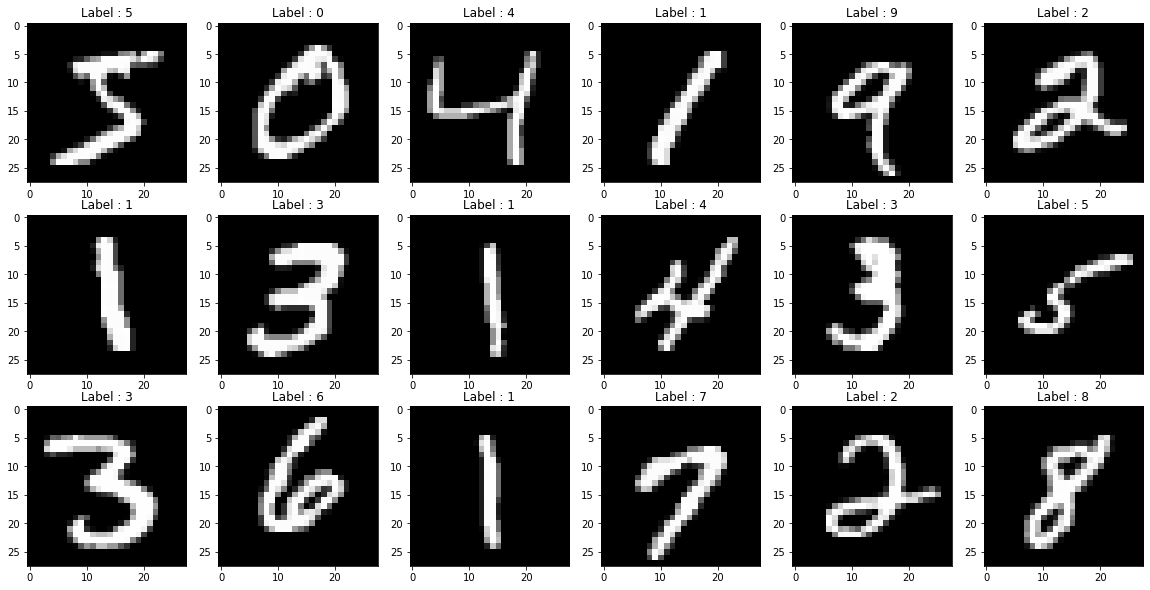

In [3]:
## MNIST Data set Preparation
mnist_train = datasets.MNIST(         # MNIST Training data set
    root=root,
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
mnist_test = datasets.MNIST(          # MNIST Test data set
    root=root,
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
print(mnist_train.targets.shape, mnist_train.targets.unique())
plot_image_mnist(data=mnist_train)

torch.Size([60000]) tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


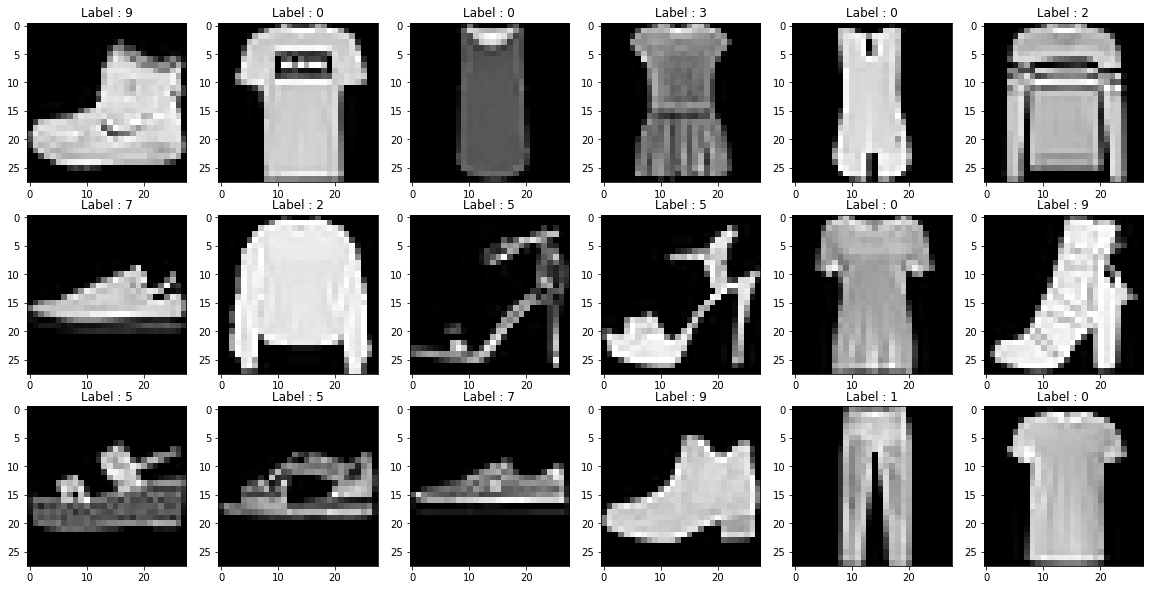

In [4]:
## FMNIST Data set Preparation
fmnist_train = datasets.FashionMNIST(         # FMNIST Training data set
    root=root,
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
fmnist_test = datasets.FashionMNIST(          # FMNIST Test data set
    root=root,
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
print(fmnist_train.targets.shape, fmnist_train.targets.unique())
plot_image_mnist(data=fmnist_train)

torch.Size([60000]) tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


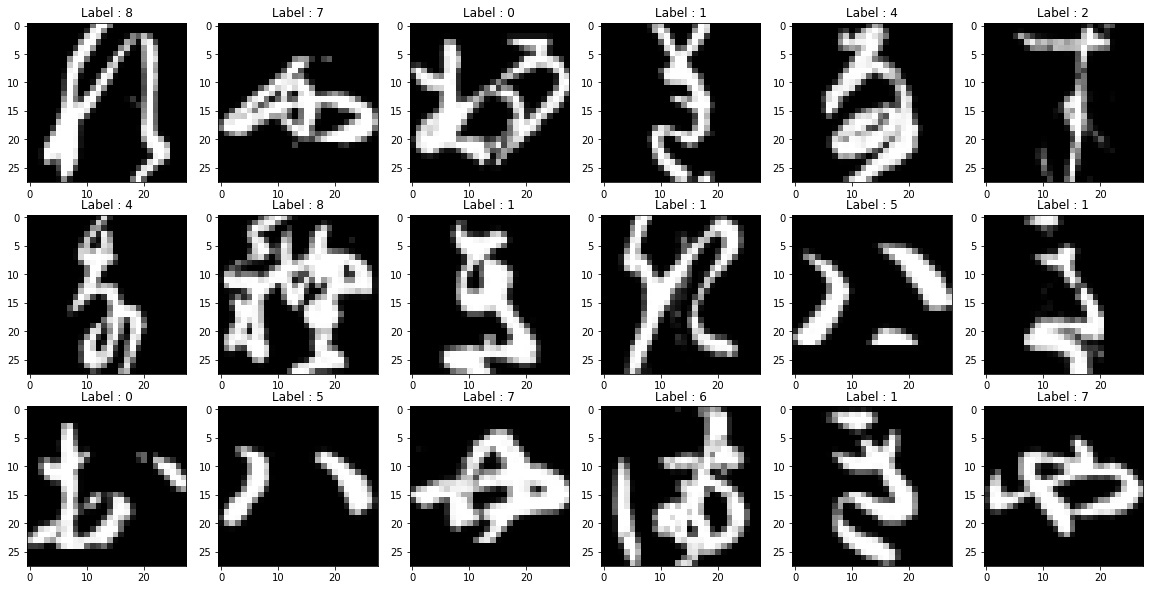

In [5]:
## KMNIST Data set Preparation
kmnist_train = datasets.KMNIST(         # KMNIST Training data set
    root=root,
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
kmnist_test = datasets.KMNIST(          # KMNIST Test data set
    root=root,
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
print(kmnist_train.targets.shape, kmnist_train.targets.unique())
plot_image_mnist(data=kmnist_train)

torch.Size([697932]) tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61])


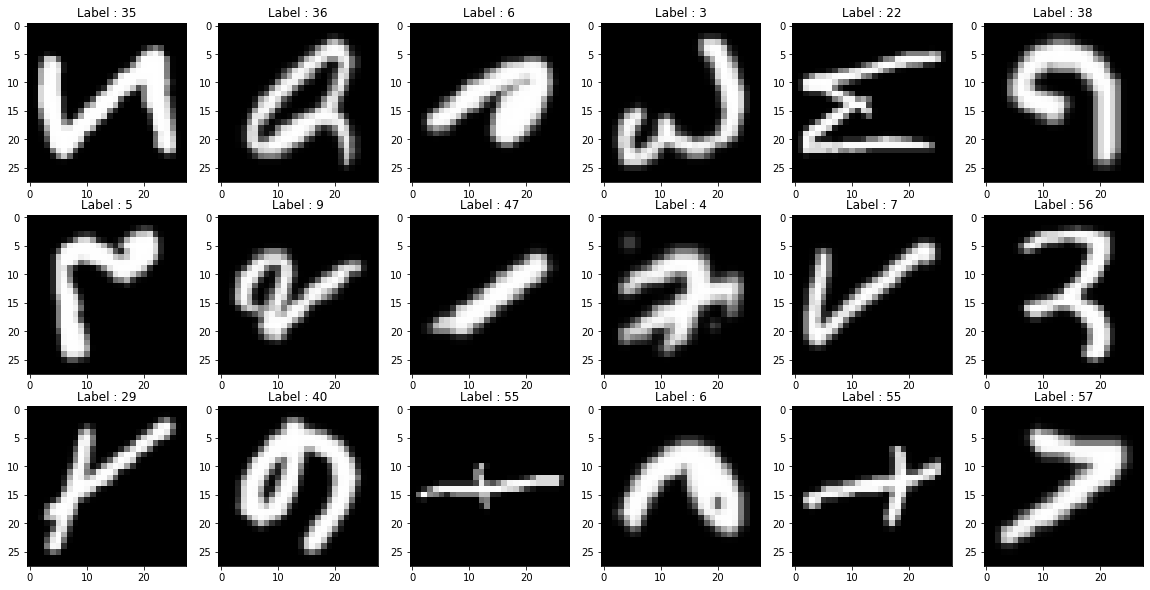

In [6]:
## EMNIST Data set Preparation
emnist_train = datasets.EMNIST(         # EMNIST Training data set
    root=root,
    split="byclass",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
emnist_test = datasets.EMNIST(          # EMNIST Test data set
    root=root,
    split="byclass",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
print(emnist_train.targets.shape, emnist_train.targets.unique())
plot_image_mnist(data=emnist_train)

## **① Training | Validation Dataset Split**

In [7]:
## Definition of Dataset Class
class image_mnist_dataset(Dataset):
  def __init__(self, data, targets, transform=None, target_transform=None):
    super().__init__()

    self.data = data
    self.targets = targets
    self.transform = transform
    self.target_transform = target_transform
    pass
  
  def __len__(self):
      return len(self.data)
  
  def __getitem__(self, idx):
    x, y = self.data[idx], self.targets[idx]

    if self.transform:
      x = self.transform(x)
    if self.target_transform:
      y = self.target_transform(y)

    return x, y


## Function Definition of Validation between Training and Validation data set
def train_valid_split(dataset, valid_ratio=0.1):
  valid_len = int(len(dataset) * valid_ratio)

  train_data = dataset.data[:-valid_len].numpy()
  valid_data = dataset.data[-valid_len:].numpy()

  train_targets = dataset.targets[:-valid_len]
  valid_targets = dataset.targets[-valid_len:]

  train = image_mnist_dataset(data=train_data, targets=train_targets, transform=dataset.transform, target_transform=dataset.target_transform)
  valid = image_mnist_dataset(data=valid_data, targets=valid_targets, transform=dataset.transform, target_transform=dataset.target_transform)

  return train, valid

mnist_train, mnist_valid = train_valid_split(dataset=mnist_train)
fmnist_train, fmnist_valid = train_valid_split(dataset=fmnist_train)
kmnist_train, kmnist_valid = train_valid_split(dataset=kmnist_train)
emnist_train, emnist_valid = train_valid_split(dataset=emnist_train)


## Definition of Total data set dictionary
image_datasets = {}
image_datasets['mnist'] = {"train" : mnist_train, "valid" : mnist_valid, "test" : mnist_test}
image_datasets['fmnist'] = {"train" : fmnist_train, "valid" : fmnist_valid, "test" : fmnist_test}
image_datasets['kmnist'] = {"train" : kmnist_train, "valid" : kmnist_valid, "test" : kmnist_test}
image_datasets['emnist'] = {"train" : emnist_train, "valid" : emnist_valid, "test" : emnist_test}

for idx in image_datasets.keys():
  print(f"Length of {idx} : Train -- {len(image_datasets[idx]['train'])} Valid -- {len(image_datasets[idx]['valid'])} Test -- {len(image_datasets[idx]['test'])}")
print()


## Definition of Dataset Loader for different kinds of dataset
loaders = {}
for idx in image_datasets.keys():
  loaders[idx] = {set_type : DataLoader(dataset=image_datasets[idx][set_type],
                                        batch_size=512 if idx == "emnist" else 64,
                                        shuffle=set_type == "train",
                                        drop_last=True) for set_type in ["train", "valid", "test"]}
loaders

Length of mnist : Train -- 54000 Valid -- 6000 Test -- 10000
Length of fmnist : Train -- 54000 Valid -- 6000 Test -- 10000
Length of kmnist : Train -- 54000 Valid -- 6000 Test -- 10000
Length of emnist : Train -- 628139 Valid -- 69793 Test -- 116323



{'mnist': {'train': <torch.utils.data.dataloader.DataLoader at 0x7fe512d65410>,
  'valid': <torch.utils.data.dataloader.DataLoader at 0x7fe5127cbb50>,
  'test': <torch.utils.data.dataloader.DataLoader at 0x7fe512d65710>},
 'fmnist': {'train': <torch.utils.data.dataloader.DataLoader at 0x7fe512d656d0>,
  'valid': <torch.utils.data.dataloader.DataLoader at 0x7fe512d65f50>,
  'test': <torch.utils.data.dataloader.DataLoader at 0x7fe512d65050>},
 'kmnist': {'train': <torch.utils.data.dataloader.DataLoader at 0x7fe512d65b90>,
  'valid': <torch.utils.data.dataloader.DataLoader at 0x7fe512d65550>,
  'test': <torch.utils.data.dataloader.DataLoader at 0x7fe512d65d10>},
 'emnist': {'train': <torch.utils.data.dataloader.DataLoader at 0x7fe512d65a10>,
  'valid': <torch.utils.data.dataloader.DataLoader at 0x7fe512d658d0>,
  'test': <torch.utils.data.dataloader.DataLoader at 0x7fe512d65c10>}}

## **② AI Model Building + Trainer Class Definition**

In [11]:
## ANN(MLP) Classifier Modeling for MNIST Image Data set
class ANNImageMNISTClassifier(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    self.model = nn.Sequential(
        nn.Flatten(),               # nn.Flatten() => 2D Image 형식의 data를 연속된 array의 형태로 반환하는 function
        nn.Linear(28 * 28, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, n_class)
    )
  
  def forward(self, x):
    return self.model(x)

ann_mlp = ANNImageMNISTClassifier()
ann_mlp
print()

## Define Trainer of ANN Classifier Model
class ANNMLPTrainer(nn.Module):
  def __init__(self, model_class, loaders, n_class=10, opt='sgd', lr=0.001, has_scheduler=False, device='cuda'):
    super().__init__()

    self.model = model_class(n_class=n_class)
    self.loss = nn.CrossEntropyLoss()

    self.train_loader = loaders["train"]
    self.valid_loader = loaders["valid"]
    self.test_loader = loaders["test"]

    self._get_optimizer(opt=opt.lower(), lr=lr)
    self.has_scheduler = has_scheduler
    if self.has_scheduler:
      self._get_scheduler()
    
    self.device = device
    pass
  
  def _get_optimizer(self, opt, lr=0.001):    # 학습에 사용할 Optimizer 정의
    if opt == "sgd":
      self.optimizer = torch.optim.SGD(params=self.model.parameters(), lr=lr)
    elif opt == "adagrad":
      self.optimizer = torch.optim.Adagrad(params=self.model.parameters(), lr=lr)
    elif opt == "adadelta":
      self.optimizer = torch.optim.Adadelta(params=self.model.parameters(), lr=lr)
    elif opt == "rmsprop":
      self.optimizer = torch.optim.RMSprop(params=self.model.parameters(), lr=lr)
    elif opt == "adam":
      self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=lr)
    else:
      raise ValueError(f"Inputted Optimizer {opt} is not Supported")
  
  def _get_scheduler(self):                   # 학습에 사용할 Learning rate Scheduler 정의
    self.scheduler = torch.optim.lr_scheduler.StepLR(optimizer=self.optimizer, step_size=5, gamma=0.5, verbose=True)    # 학습의 총 epoch에서 step_size마다 gamma의 비율로 learning rate를 순차적으로 줄임
  
  def train(self, max_epochs=10):             # 학습 결과 도출 Process, 총 학습 round 수(epoch 수) = max_epochs
    print("======= Train Start =======")
    history = {"Train Loss" : [], "Train Acc" : [], "Valid Loss" : [], "Valid Acc" : []}    # 매 학습 epoch마다 Loss와 Accuracy를 저장할 dictionary 정의

    for epoch in range(max_epochs):
      train_loss, train_acc = self._train_epoch()
      valid_loss, valid_acc = self._valid_epoch()

      history["Train Loss"].append(train_loss)
      history["Train Acc"].append(train_acc)
      history["Valid Loss"].append(valid_loss)
      history["Valid Acc"].append(valid_acc)

      if self.has_scheduler:
        self.scheduler.step()     # has_scheduler=True이면 사전에 정의한 Learning rate Scheduler를 지정한 step_size마다 수행

      if epoch % 5 == 0:
        print(f"{epoch}/{max_epochs} Epoch ==> Train Loss : {train_loss:>6f}, Train Acc : {train_acc:>6f}, Valid Loss : {valid_loss:>6f}, Valid Acc : {valid_acc:>6f}")
    
    self.plot_history(history)

  def _train_epoch(self):       # Training Process
    train_epoch_loss, train_epoch_acc = 0, 0
    self.model.train()                          # model.train() => model을 Training mode로 전환

    for (x, y) in self.train_loader:            
      x = x.to(device=self.device)              # Numpy array가 된 Input image data를 GPU로
      y = y.to(device=self.device)              # Target class label을 GPU로

      y_hat = self.model(x)                     # ① 사전에 정의한 ANNImageMNISTClassifier model로 학습 진행 => Forward Pass, y_hat => Forward Pass의 예측 결과값
      loss = self.loss(y_hat, y)                # ② CrossEntropyLoss(for Classification Task)로 Loss function 계산

      self.optimizer.zero_grad()                # ② Forward Pass 과정에서 학습한 parameter들 -> Backward Pass로 update 진행
      loss.backward()
      self.optimizer.step()

      train_epoch_loss += loss.to("cpu").item()
      train_epoch_acc += (y_hat.argmax(1) == y).type(torch.float).to("cpu").mean().item()
    
    train_epoch_loss /= len(self.train_loader)
    train_epoch_acc /= len(self.train_loader)

    return train_epoch_loss, train_epoch_acc

  def _valid_epoch(self):       # Validation Process
    valid_epoch_loss, valid_epoch_acc = 0, 0
    self.model.eval()                           # model.eval() => model을 Validation mode로 전환, Validation 과정에서 사용하지 않을 layer들을 non-activate 상태로 전환

    with torch.no_grad():
      for (x, y) in self.valid_loader:
        x = x.to(device=self.device)
        y = y.to(device=self.device)

        y_hat = self.model(x)
        loss = self.loss(y_hat, y)

        valid_epoch_loss += loss.to("cpu").item()
        valid_epoch_acc += (y_hat.argmax(1) == y).type(torch.float).to("cpu").mean().item()

    valid_epoch_loss /= len(self.valid_loader)
    valid_epoch_acc /= len(self.valid_loader)

    return valid_epoch_loss, valid_epoch_acc

  def plot_history(self, history):
    fig = plt.figure(figsize=(20, 10))

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history["Train Loss"], color="red", label="Train Loss")
    ax.plot(history["Valid Loss"], color="orange", label="Valid Loss")
    ax.set_title("Loss")
    ax.legend()

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history["Train Acc"], color="red", label="Train Accuracy")
    ax.plot(history["Valid Acc"], color="orange", label="Valid Accuracy")
    ax.set_title("Accuracy")
    ax.legend()

    fig.show()

  def test(self):       # Test Process
    print("======= Test Start =======")
    test_epoch_loss, test_epoch_acc = 0, 0
    self.model.eval()

    with torch.no_grad():
      for (x, y) in self.test_loader:
        x = x.to(self.device)
        y = y.to(self.device)

        y_hat = self.model(x)
        loss = self.loss(y_hat, y)

        test_epoch_loss += loss.to("cpu").item()
        test_epoch_acc += (y_hat.argmax(1) == y).type(torch.float).to("cpu").mean().item()

    test_epoch_loss /= len(self.test_loader)
    test_epoch_acc /= len(self.test_loader)

    print(f"Test loss: {test_epoch_loss:>6f}, Test acc: {test_epoch_acc:>3f}")

## **③ Training + Validation + Test ANN Model for each Dataset**

### *MNIST Dataset Training + Test Process*

======= Train Start =======
0/30 Epoch ==> Train Loss : 0.307983, Train Acc : 0.909772, Valid Loss : 0.114288, Valid Acc : 0.967742
5/30 Epoch ==> Train Loss : 0.030973, Train Acc : 0.990028, Valid Loss : 0.074565, Valid Acc : 0.979671
10/30 Epoch ==> Train Loss : 0.013936, Train Acc : 0.995311, Valid Loss : 0.099850, Valid Acc : 0.980847
15/30 Epoch ==> Train Loss : 0.006591, Train Acc : 0.997720, Valid Loss : 0.113622, Valid Acc : 0.980511
20/30 Epoch ==> Train Loss : 0.007183, Train Acc : 0.997516, Valid Loss : 0.124167, Valid Acc : 0.981183
25/30 Epoch ==> Train Loss : 0.006382, Train Acc : 0.998054, Valid Loss : 0.150491, Valid Acc : 0.980007
======= Test Start =======
Test loss: 0.152786, Test acc: 0.978165


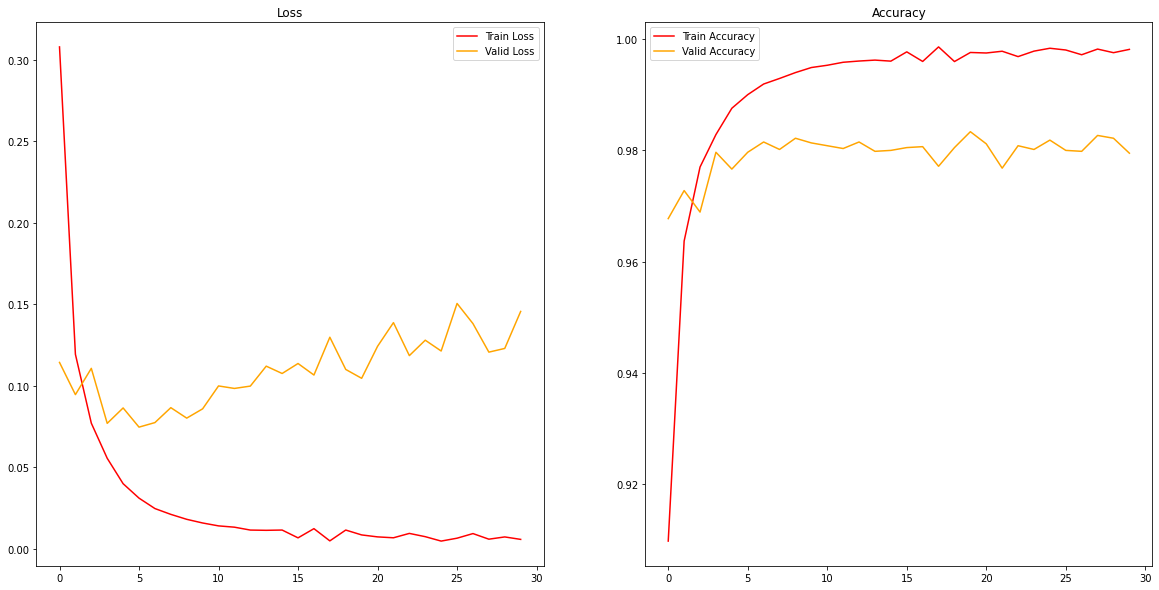

In [12]:
mnist_trainer = ANNMLPTrainer(model_class=ANNImageMNISTClassifier, loaders=loaders["mnist"], n_class=10, opt="adam", lr=0.001, device=device).to(device)
mnist_trainer.train(max_epochs=30)
mnist_trainer.test()

### *FMNIST Dataset Training + Test Process*

======= Train Start =======
0/30 Epoch ==> Train Loss : 0.535117, Train Acc : 0.808274, Valid Loss : 0.393595, Valid Acc : 0.857527
5/30 Epoch ==> Train Loss : 0.277135, Train Acc : 0.897798, Valid Loss : 0.316356, Valid Acc : 0.885417
10/30 Epoch ==> Train Loss : 0.219465, Train Acc : 0.917278, Valid Loss : 0.319066, Valid Acc : 0.888105
15/30 Epoch ==> Train Loss : 0.181958, Train Acc : 0.930401, Valid Loss : 0.327753, Valid Acc : 0.895329
20/30 Epoch ==> Train Loss : 0.153521, Train Acc : 0.940391, Valid Loss : 0.373322, Valid Acc : 0.890457
25/30 Epoch ==> Train Loss : 0.128420, Train Acc : 0.950289, Valid Loss : 0.370435, Valid Acc : 0.894657
======= Test Start =======
Test loss: 0.448567, Test acc: 0.887620


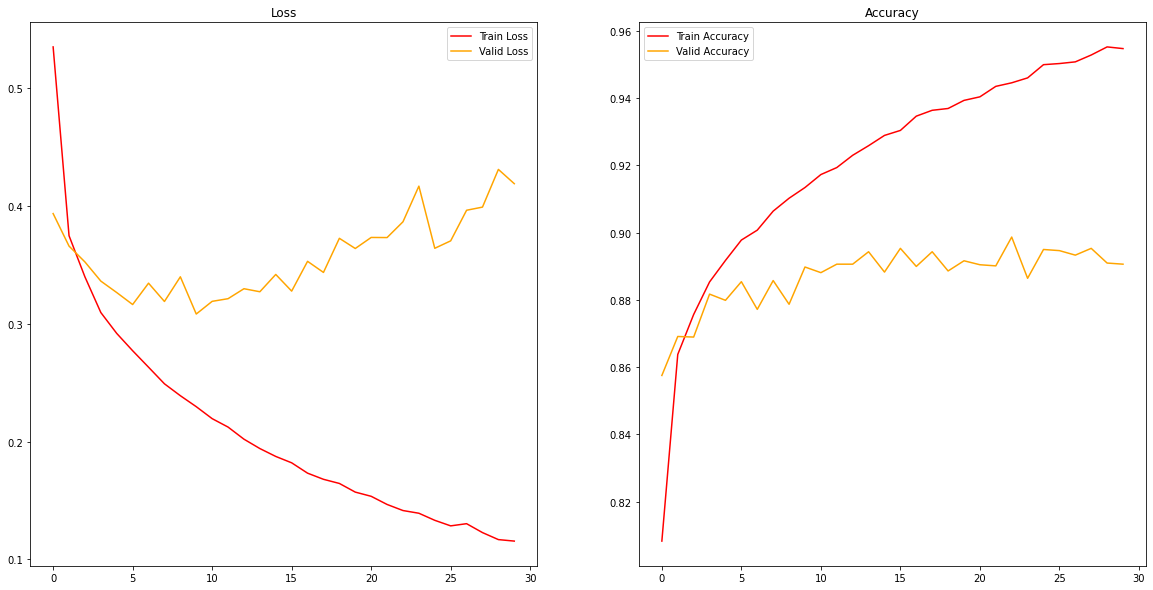

In [13]:
fmnist_trainer = ANNMLPTrainer(model_class=ANNImageMNISTClassifier, loaders=loaders["fmnist"], n_class=10, opt="adam", lr=0.001, device=device).to(device)
fmnist_trainer.train(max_epochs=30)
fmnist_trainer.test()

### *KMNIST Dataset Training + Test Process*

======= Train Start =======
0/30 Epoch ==> Train Loss : 0.451656, Train Acc : 0.863490, Valid Loss : 0.267354, Valid Acc : 0.921203
5/30 Epoch ==> Train Loss : 0.043303, Train Acc : 0.986266, Valid Loss : 0.156310, Valid Acc : 0.957661
10/30 Epoch ==> Train Loss : 0.014556, Train Acc : 0.995218, Valid Loss : 0.228341, Valid Acc : 0.956653
15/30 Epoch ==> Train Loss : 0.012708, Train Acc : 0.996034, Valid Loss : 0.231594, Valid Acc : 0.961022
20/30 Epoch ==> Train Loss : 0.010046, Train Acc : 0.996775, Valid Loss : 0.268783, Valid Acc : 0.958501
25/30 Epoch ==> Train Loss : 0.009034, Train Acc : 0.997109, Valid Loss : 0.280464, Valid Acc : 0.961862
======= Test Start =======
Test loss: 0.804755, Test acc: 0.905549


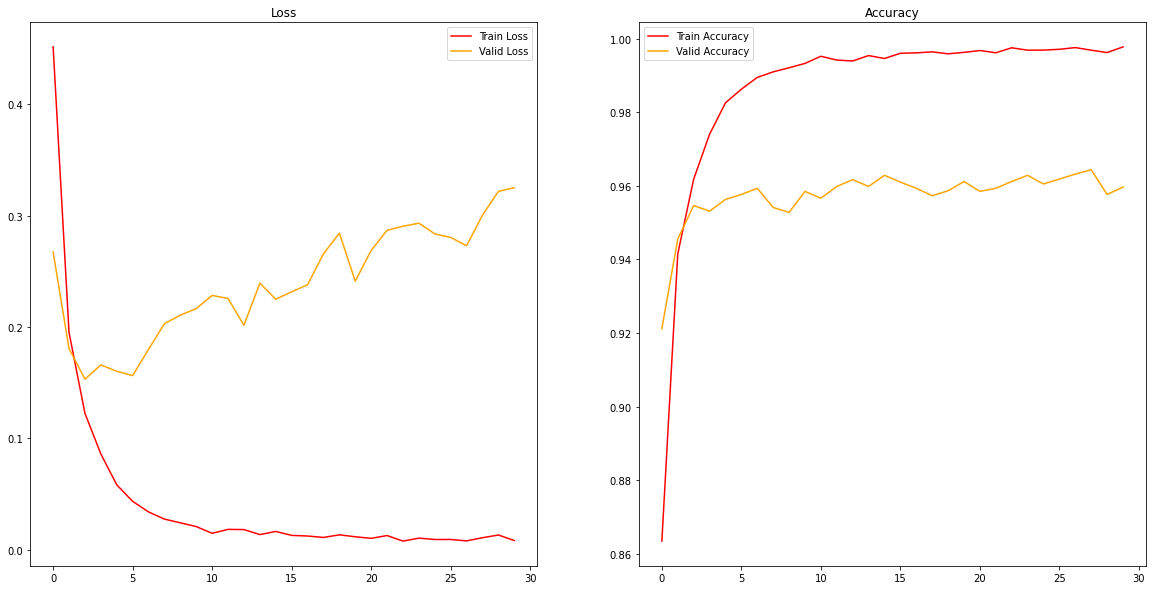

In [14]:
kmnist_trainer = ANNMLPTrainer(model_class=ANNImageMNISTClassifier, loaders=loaders["kmnist"], n_class=10, opt="adam", lr=0.001, device=device).to(device)
kmnist_trainer.train(max_epochs=30)
kmnist_trainer.test()

### *EMNIST Dataset Training + Test Process*

======= Train Start =======
0/5 Epoch ==> Train Loss : 0.875476, Train Acc : 0.744327, Valid Loss : 0.588759, Valid Acc : 0.808177
======= Test Start =======
Test loss: 0.446585, Test acc: 0.844077


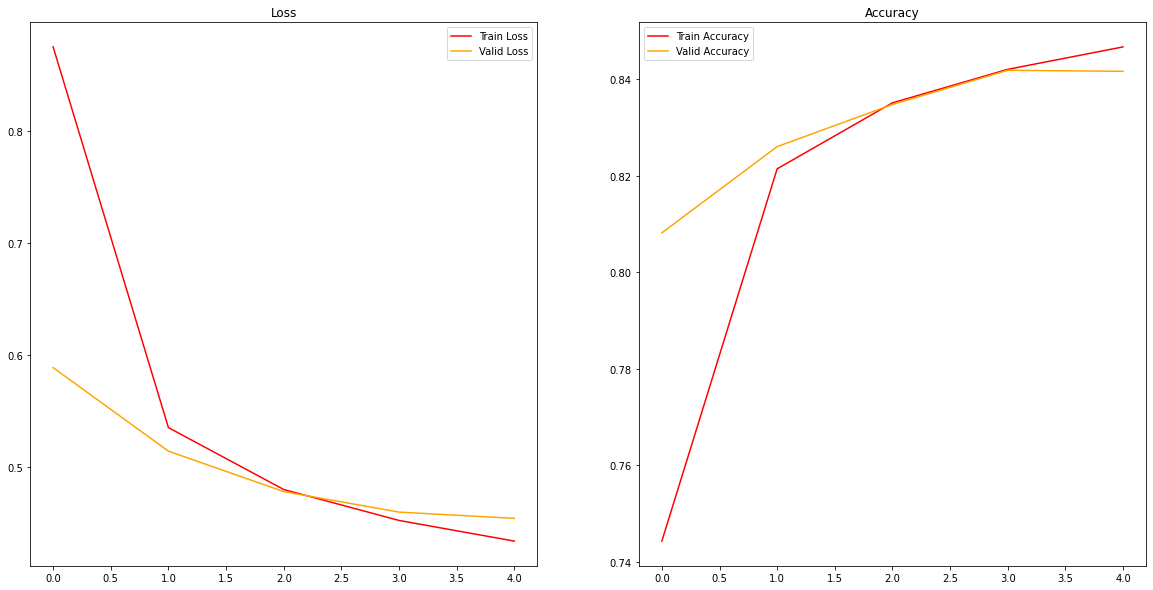

In [16]:
emnist_trainer = ANNMLPTrainer(model_class=ANNImageMNISTClassifier, loaders=loaders["emnist"], n_class=62, opt="adam", lr=0.001, device=device).to(device)
emnist_trainer.train(max_epochs=5)
emnist_trainer.test()

## **④ AI Model Building with Drop-Out and Batch-Normalization**  
- **Drop-Out** : 매번 Forward Pass 시 전체 parameter 중 일부를 0의 값으로 대체하여 model의 전체 parameter 중 일부만을 사용해도 좋은 성능을 낼 수 있게 유도하는 기법  
- **Batch-Normalization** : 각각의 layer에서 발생하는 Activation value는 Non-Gaussian 형태이므로, Mini-batch 단위로 Normalization을 적용하여 각 layer마다 같은 Activation 분포를 유지하는 기법

In [21]:
## ① ANN(MLP) Classifier Modeling with Drop-Out Algorithm
class ANNImageWithDropOutClassifier(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    self.model = nn.Sequential(
        nn.Flatten(),               # nn.Flatten() => 2D Image 형식의 data를 연속된 array의 형태로 반환하는 function
        nn.Linear(28 * 28, 256),
        nn.Dropout(p=0.5),          # Drop-out 추가 => 매 Forward Pass마다 전체 parameter중 0.5만큼의 parameter 갯수를 0으로 대체
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.Dropout(p=0.5),
        nn.ReLU(),
        nn.Linear(128, n_class)
    )
  
  def forward(self, x):
    return self.model(x)


## ② ANN(MLP) Classifier Modeling with Batch-Normalization Algorithm
class ANNImageWithBNClassifier(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    self.model = nn.Sequential(
        nn.Flatten(),               # nn.Flatten() => 2D Image 형식의 data를 연속된 array의 형태로 반환하는 function
        nn.Linear(28 * 28, 256),
        nn.BatchNorm1d(256),        # Batch-Normalization 추가 => Mini-batch 단위로 Activation value를 Normalize 
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Linear(128, n_class)
    )
  
  def forward(self, x):
    return self.model(x)


## ③ ANN(MLP) Classifier Modeling with Drop-Out and Batch-Normalization Algorithm
class ANNImageWithDropOutandBNClassifier(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    self.model = nn.Sequential(
        nn.Flatten(),               # nn.Flatten() => 2D Image 형식의 data를 연속된 array의 형태로 반환하는 function
        nn.Linear(28 * 28, 256),
        nn.BatchNorm1d(256),
        nn.Dropout(p=0.5),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.Dropout(p=0.5),
        nn.ReLU(),
        nn.Linear(128, n_class)
    )
  
  def forward(self, x):
    return self.model(x)

### *FMNIST Dataset Training + Test Process using "Drop-Out"*

======= Train Start =======
0/30 Epoch ==> Train Loss : 0.705930, Train Acc : 0.743364, Valid Loss : 0.462557, Valid Acc : 0.837198
5/30 Epoch ==> Train Loss : 0.404734, Train Acc : 0.854333, Valid Loss : 0.348736, Valid Acc : 0.869288
10/30 Epoch ==> Train Loss : 0.368429, Train Acc : 0.866085, Valid Loss : 0.340827, Valid Acc : 0.872816
15/30 Epoch ==> Train Loss : 0.345463, Train Acc : 0.870403, Valid Loss : 0.328281, Valid Acc : 0.875672
20/30 Epoch ==> Train Loss : 0.332036, Train Acc : 0.878485, Valid Loss : 0.335209, Valid Acc : 0.873824
25/30 Epoch ==> Train Loss : 0.321445, Train Acc : 0.882952, Valid Loss : 0.314749, Valid Acc : 0.886593
======= Test Start =======
Test loss: 0.341273, Test acc: 0.878205


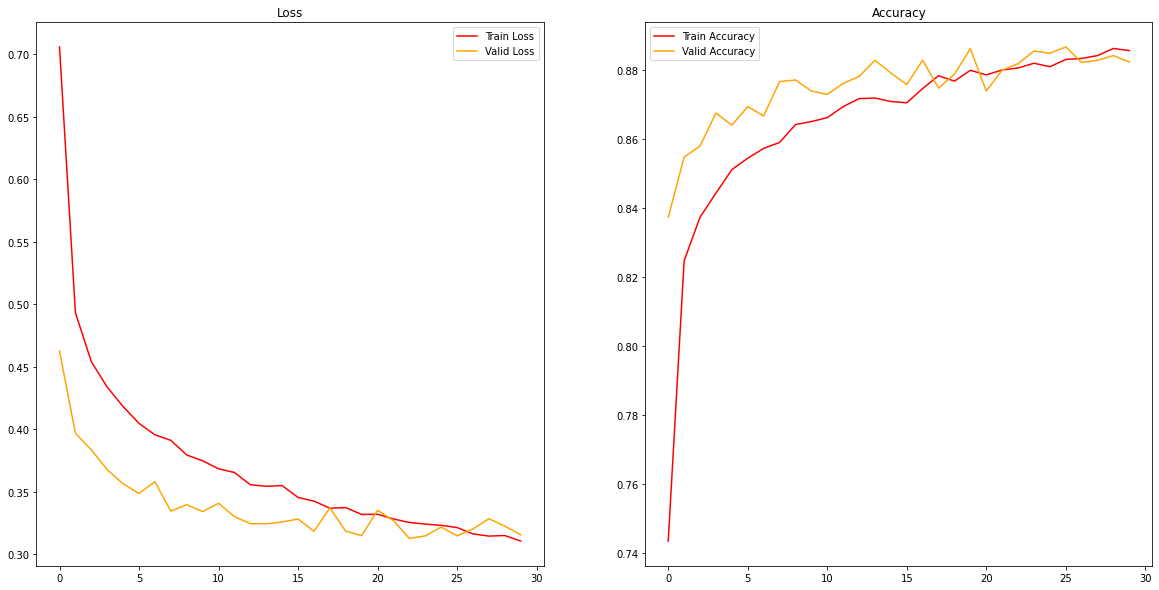

In [18]:
fmnist_dropout_trainer = ANNMLPTrainer(model_class=ANNImageWithDropOutClassifier, loaders=loaders["fmnist"], n_class=10, opt="adam", lr=0.001, device=device).to(device)
fmnist_dropout_trainer.train(max_epochs=30)
fmnist_dropout_trainer.test()

### *FMNIST Dataset Training + Test Process using "Batch-Normalization"*

======= Train Start =======
0/30 Epoch ==> Train Loss : 0.457972, Train Acc : 0.840099, Valid Loss : 0.374123, Valid Acc : 0.863071
5/30 Epoch ==> Train Loss : 0.236144, Train Acc : 0.911162, Valid Loss : 0.332036, Valid Acc : 0.882560
10/30 Epoch ==> Train Loss : 0.176019, Train Acc : 0.933886, Valid Loss : 0.320864, Valid Acc : 0.892305
15/30 Epoch ==> Train Loss : 0.131907, Train Acc : 0.949251, Valid Loss : 0.373855, Valid Acc : 0.885753
20/30 Epoch ==> Train Loss : 0.105407, Train Acc : 0.961225, Valid Loss : 0.372325, Valid Acc : 0.892641
25/30 Epoch ==> Train Loss : 0.080293, Train Acc : 0.969973, Valid Loss : 0.415842, Valid Acc : 0.891969
======= Test Start =======
Test loss: 0.530010, Test acc: 0.880108


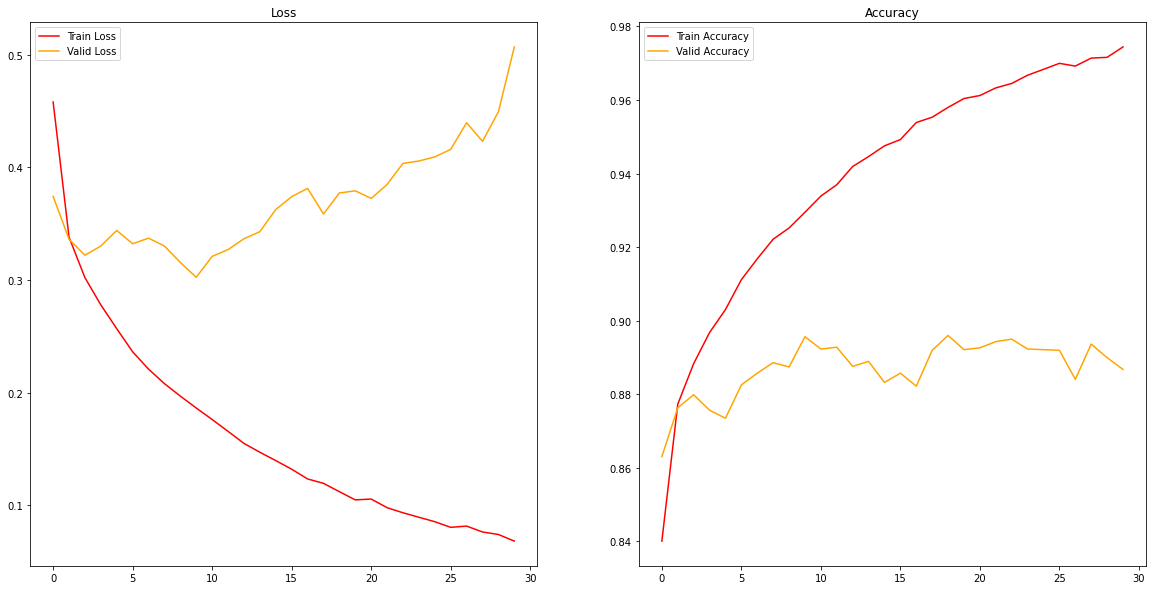

In [19]:
fmnist_bn_trainer = ANNMLPTrainer(model_class=ANNImageWithBNClassifier, loaders=loaders["fmnist"], n_class=10, opt="adam", lr=0.001, device=device).to(device)
fmnist_bn_trainer.train(max_epochs=30)
fmnist_bn_trainer.test()

### *FMNIST Dataset Training + Test Process using "Drop-Out and Batch-Normalization"*

======= Train Start =======
0/30 Epoch ==> Train Loss : 0.629767, Train Acc : 0.786922, Valid Loss : 0.402828, Valid Acc : 0.848454
5/30 Epoch ==> Train Loss : 0.385968, Train Acc : 0.860079, Valid Loss : 0.324645, Valid Acc : 0.878528
10/30 Epoch ==> Train Loss : 0.343575, Train Acc : 0.874963, Valid Loss : 0.302418, Valid Acc : 0.887097
15/30 Epoch ==> Train Loss : 0.317863, Train Acc : 0.884879, Valid Loss : 0.295046, Valid Acc : 0.892305
20/30 Epoch ==> Train Loss : 0.292972, Train Acc : 0.892682, Valid Loss : 0.290656, Valid Acc : 0.894153
25/30 Epoch ==> Train Loss : 0.283786, Train Acc : 0.896964, Valid Loss : 0.293211, Valid Acc : 0.894153
======= Test Start =======
Test loss: 0.314564, Test acc: 0.889423


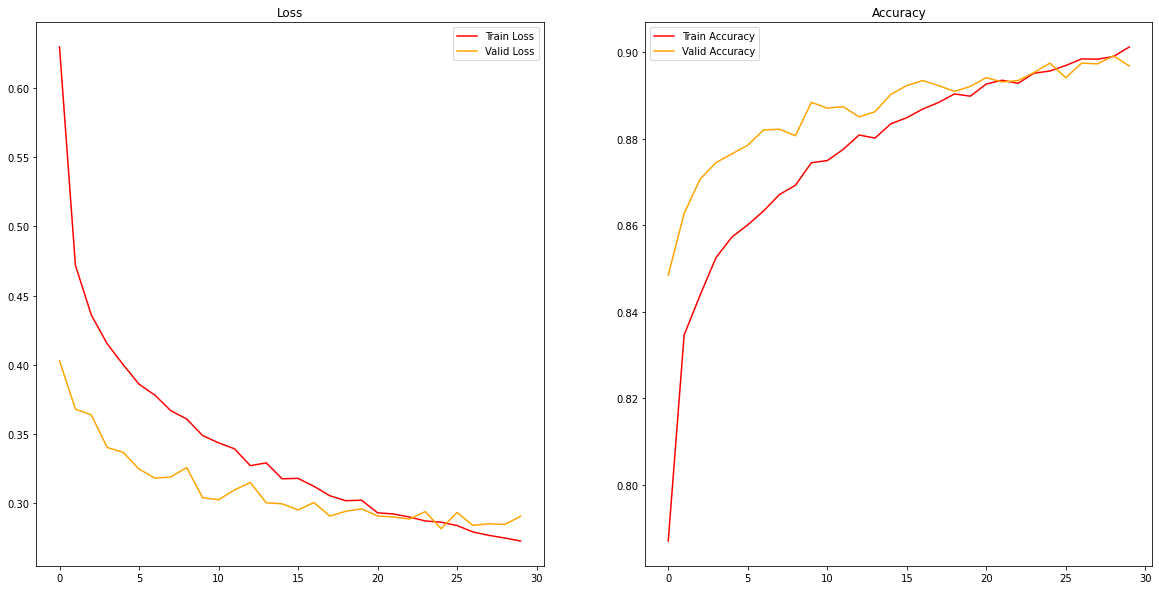

In [20]:
fmnist_dropout_bn_trainer = ANNMLPTrainer(model_class=ANNImageWithDropOutandBNClassifier, loaders=loaders["fmnist"], n_class=10, opt="adam", lr=0.001, device=device).to(device)
fmnist_dropout_bn_trainer.train(max_epochs=30)
fmnist_dropout_bn_trainer.test()